In [7]:
def show_particle_ids():
    print("""
Particle Identifiers for QGRAF:
--------------------------------
* UPQ  = upbar (anti-up quark)
* upq  = up (up quark)
* glu  = gluon
* gh   = ghost
* GH   = anti-ghost
* Model: QCDGRHIGGS
--------------------------------
    """)

def modify_qgraf_input():
    # Show particle identities to the user
    show_particle_ids()

    # Ask for the process input
    process = input("Enter the process (e.g., glu glu > upq UPQ): ").strip()

    # Ask for the output filename
    output_filename = input("Enter the output filename (e.g., gg2uU_LO.qgraf): ").strip()

    # Parse the process input
    in_particles, out_particles = process.split('>')
    in_particles = [p.strip() for p in in_particles.split()]
    out_particles = [p.strip() for p in out_particles.split()]
    
    # Generate the momentum assignment
    in_momenta = [f"{particle}[p{i+1}]" for i, particle in enumerate(in_particles)]
    out_momenta = [f"{particle}[p{i+3}]" for i, particle in enumerate(out_particles)]

    # Prepare the content for the qgraf.dat file
    qgraf_content = f"""
output= '{output_filename}';
style= 'form_v1.sty';
model= 'QCDGRHIGGS';
in= {', '.join(in_momenta)};
out= {', '.join(out_momenta)};
loops= 0;
loop_momentum=k;
options= notadpole, nosnail, onshell;
*true = vsum[gs, 1, 2];
*false = vsum[kap,2,2];
*false = vsum[ew, 1, 2];
*true = vsum[ew, 1, 2];
*true = vsum[kap, 1, 2];
*true = vsum[kq, 1, 2];

* To remove qcd vertex only at oneloop
*true = vsum[gs, 1, 1];
* To keep qcd vertex only at oneloop
"""
    # Write the modified content to qgraf.dat
    with open('Qgraf/qgraf.dat', 'w') as file:
        file.write(qgraf_content)
    
    print("qgraf.dat file has been updated.")

if __name__ == "__main__":
    modify_qgraf_input()



Particle Identifiers for QGRAF:
--------------------------------
* UPQ  = upbar (anti-up quark)
* upq  = up (up quark)
* glu  = gluon
* gh   = ghost
* GH   = anti-ghost
* Model: QCDGRHIGGS
--------------------------------
    


Enter the process (e.g., glu glu > upq UPQ):  glu glu > upq UPQ
Enter the output filename (e.g., gg2uU_LO.qgraf):  gg2uU_LO.qgraf


qgraf.dat file has been updated.


In [3]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:00:010m


In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import os

current_dir = os.getcwd()

# Construct the full path to the Qgraf directory
qgraf_dir = os.path.join(current_dir, "Qgraf")

modified_output_filename =  "Qgraf/gg2uU_LO.qgraf"
print(modified_output_filename)

Qgraf/gg2uU_LO.qgraf


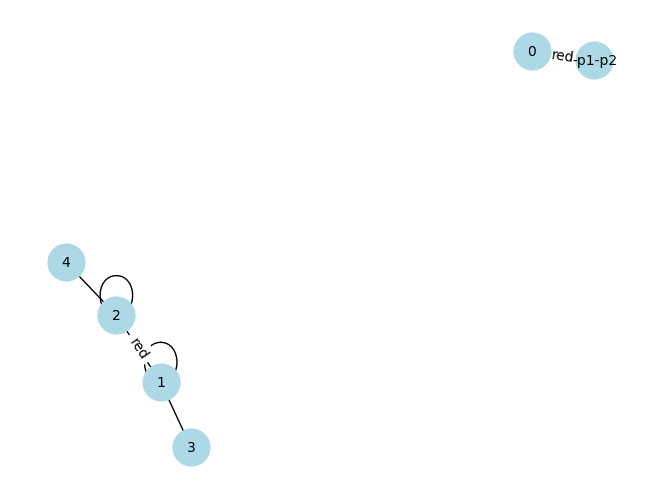

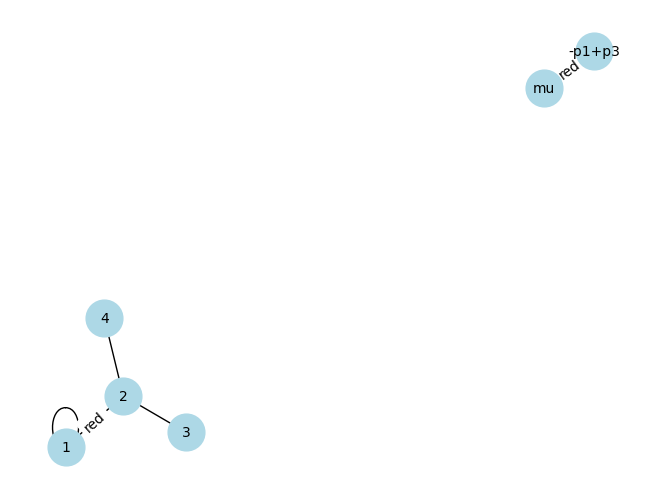

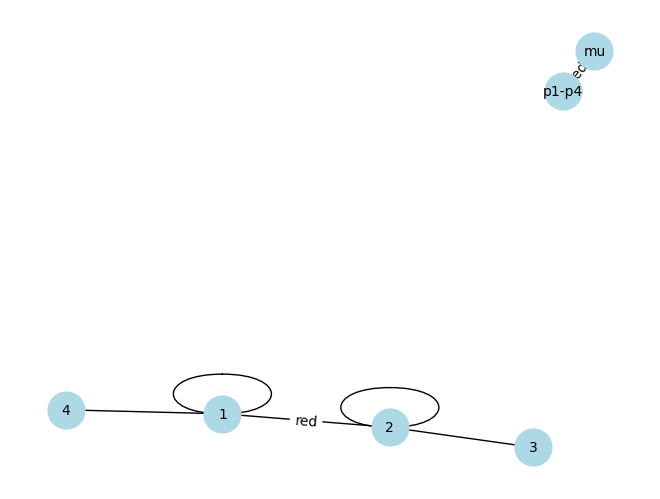

In [18]:
import matplotlib.pyplot as plt
import networkx as nx
import re

# Function to read the QGRAF output and extract diagrams
def read_qgraf_output(output_filename):
    diagrams = []
    with open(output_filename, 'r') as file:
        in_diagram = False
        current_diagram = []
        for line in file:
            line = line.strip()
            if line.startswith('*--#[ d'):  # Start of a new diagram
                in_diagram = True
                current_diagram = []
            elif line.startswith('*--#] d'):  # End of the diagram
                in_diagram = False
                diagrams.append('\n'.join(current_diagram))
            elif in_diagram:
                current_diagram.append(line)
    return diagrams

# Function to parse vertices and propagators
def parse_diagram(diagram):
    vertices = []
    propagators = []
    
    for line in diagram.splitlines():
        line = line.strip()
        if line.startswith('Vx'):
            # Parse vertices: Vx(1,3,glugluglu,-1,-3,1,p1,p2,-p1-p2)
            parts = re.split(r'[(),]', line)
            vertex_id = parts[1].strip()
            num_particles = int(parts[2].strip())
            vertex_type = parts[3].strip()
            connections = [p.strip() for p in parts[4:num_particles+4]]
            momenta = [p.strip() for p in parts[num_particles+4:]]
            vertices.append((vertex_id, num_particles, vertex_type, connections, momenta))
        elif line.startswith('GG') or line.startswith('QQ'):
            # Parse propagators: GG(1,2,-p1-p2,0) or QQ(1,2,-p1+p3,mu)
            parts = re.split(r'[(),]', line)
            propagator_type = parts[0].strip()
            connections = [p.strip() for p in parts[1:] if p.strip()]  # Filter empty strings
            propagators.append((propagator_type, connections))
    
    return vertices, propagators

# Function to plot diagrams
def plot_diagram(vertices, propagators):
    G = nx.Graph()
    
    # Add vertices and connections
    for vertex_id, num_particles, vertex_type, connections, momenta in vertices:
        G.add_node(vertex_id, label=f'Vx {vertex_type}')
        for connection in connections:
            if connection.startswith('-'):
                particle_name = connection.split('[')[0].strip('-')
                G.add_node(particle_name, label=particle_name)
                G.add_edge(vertex_id, particle_name)
    
    # Add propagators
    for propagator_type, connections in propagators:
        for i in range(0, len(connections), 2):
            # Check if there are at least 2 connections
            if i + 1 < len(connections):
                start, end = connections[i], connections[i+1]
                G.add_edge(start, end, color='red')
    
    # Plot the graph
    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G, 'color')
    
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.5)
    plt.show()

# Main function to read and plot the Feynman diagrams
def plot_feynman_diagrams(output_filename):
    diagrams = read_qgraf_output(output_filename)
    
    for diagram in diagrams:
        vertices, propagators = parse_diagram(diagram)
        plot_diagram(vertices, propagators)

# Example call after generating the diagrams
plot_feynman_diagrams("Qgraf/gg2uU_LO.qgraf")


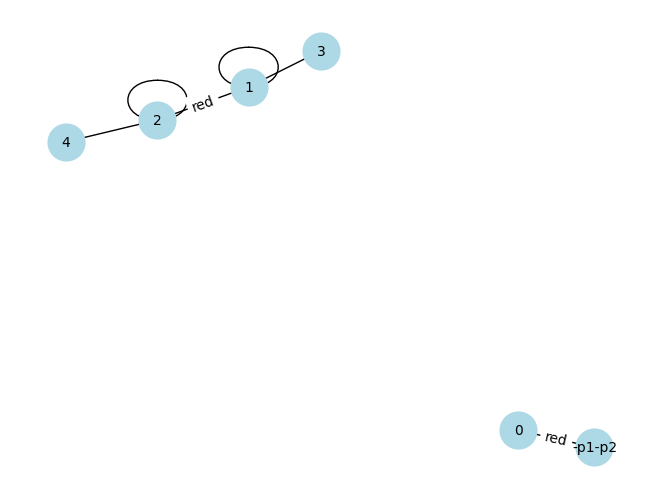

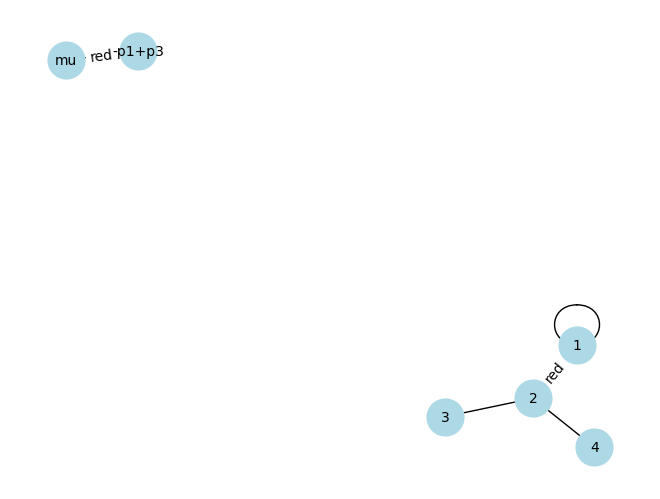

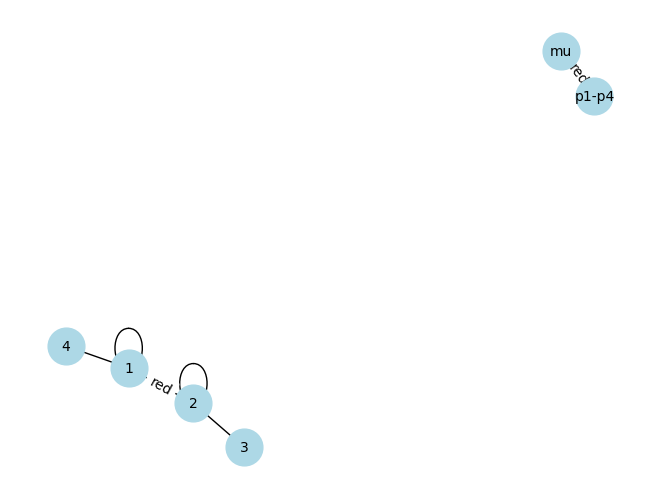

In [19]:
plot_feynman_diagrams("Qgraf/gg2uU_LO.qgraf")